In [1]:
import pandas as pd
import numpy as np
import os
import time
from fbprophet import Prophet
import matplotlib.pyplot as plt
%matplotlib inline 

#### Import Dataset

<i>Note: data is starts at Jan 2016</i>

In [2]:
data = pd.read_csv("consolidated_coin_data.csv")

#### Rename Columns (to be used later for prophet)

In [3]:
data.rename(columns={'High':'y','Date':'ds'}, inplace=True)

#### Quick Peek at the Data

In [4]:
data.head()

,Currency,ds,Open,y,Low,Close,Volume,Market Cap
0,0x,27-Dec-17,0.648181,0.712597,0.617503,0.669701,"11,866,800","306,131,000"
1,0x,26-Dec-17,0.693401,0.708796,0.563918,0.647725,"12,996,000","327,270,000"
2,0x,25-Dec-17,0.634725,0.717725,0.630453,0.696416,"8,668,880","317,362,000"
3,0x,24-Dec-17,0.651100,0.672352,0.534855,0.628460,"11,478,700","325,550,000"
4,0x,23-Dec-17,0.502023,0.768043,0.485584,0.645686,"24,164,900","251,012,000"


#### Count occurances of currency to get its age in days

In [5]:
currency_count = data['Currency'].value_counts()
currency_count

nxt                     727
bitcoindark             727
factom                  727
reddcoin                727
stellar                 727
counterparty            727
feathercoin             727
maidsafecoin            727
burst                   727
bytecoin-bcn            727
bitshares               727
syscoin                 727
dash                    727
cloakcoin               727
verge                   727
gulden                  727
namecoin                727
viacoin                 727
faircoin                727
einsteinium             727
shift                   727
litecoin                727
monero                  727
nem                     727
emercoin                727
gamecredits             727
nav-coin                727
digitalnote             727
vertcoin                727
dogecoin                727
                       ... 
amber                    66
modum                    66
bitcoin-gold             66
kucoin-shares            65
open-trading-network

In [6]:
currency_count.index

Index(['nxt', 'bitcoindark', 'factom', 'reddcoin', 'stellar', 'counterparty',
       'feathercoin', 'maidsafecoin', 'burst', 'bytecoin-bcn',
       ...
       'blockv', 'ethlend', 'dragonchain', 'cybermiles', 'iot-chain', 'wabi',
       'storm', 'aelf', 'wax', 'bread'],
      dtype='object', length=200)

#### Dont include currencies before a certain threshold

In [7]:
threshold = 50
currency_above_threshold = currency_count.index[data['Currency'].value_counts()>threshold]

In [8]:
currency_above_threshold = currency_above_threshold.tolist()

#### Currencies that are above the threshold

In [9]:
currency_above_threshold

['nxt',
 'bitcoindark',
 'factom',
 'reddcoin',
 'stellar',
 'counterparty',
 'feathercoin',
 'maidsafecoin',
 'burst',
 'bytecoin-bcn',
 'bitshares',
 'syscoin',
 'dash',
 'cloakcoin',
 'verge',
 'gulden',
 'namecoin',
 'viacoin',
 'faircoin',
 'einsteinium',
 'shift',
 'litecoin',
 'monero',
 'nem',
 'emercoin',
 'gamecredits',
 'nav-coin',
 'digitalnote',
 'vertcoin',
 'dogecoin',
 'potcoin',
 'aeon',
 'paccoin',
 'nexus',
 'blocknet',
 'ripple',
 'bitbay',
 'digibyte',
 'blackcoin',
 'bitcoin',
 'monacoin',
 'groestlcoin',
 'ethereum',
 'tether',
 'sibcoin',
 'peercoin',
 'siacoin',
 'pura',
 'hempcoin',
 'whitecoin',
 'supernet-unity',
 'ubiq',
 'agoras-tokens',
 'salus',
 'decred',
 'pivx',
 'voxels',
 'lisk',
 'augur',
 'steem',
 'digixdao',
 'waves',
 'rise',
 'ion',
 'library-credit',
 'ethereum-classic',
 'stratis',
 'neo',
 'ardor',
 'firstblood',
 'iconomi',
 'pepe-cash',
 'singulardtv',
 'zcoin',
 'triggers',
 'zcash',
 'zclassic',
 'lykke',
 'golem-network-tokens',
 'xp',

#### Split Data into train and test per each currency and add into a dictionary

In [10]:
data_dict_train = {}
data_dict_test = {}

In [11]:
for currency in currency_above_threshold:
    _ = data[data['Currency']==currency]
    _.index = pd.to_datetime(_['ds'])
    #_ = _.drop(['Date'],axis = 1)
    data_dict_test[currency] = _[:30]
    data_dict_train[currency] = _[30:]
    

#### View the dictionary

In [12]:
data_dict_test['0x'].head()

,Currency,ds,Open,y,Low,Close,Volume,Market Cap
ds,,,,,,,,
2017-12-27,0x,27-Dec-17,0.648181,0.712597,0.617503,0.669701,"11,866,800","306,131,000"
2017-12-26,0x,26-Dec-17,0.693401,0.708796,0.563918,0.647725,"12,996,000","327,270,000"
2017-12-25,0x,25-Dec-17,0.634725,0.717725,0.630453,0.696416,"8,668,880","317,362,000"
2017-12-24,0x,24-Dec-17,0.651100,0.672352,0.534855,0.628460,"11,478,700","325,550,000"
2017-12-23,0x,23-Dec-17,0.502023,0.768043,0.485584,0.645686,"24,164,900","251,012,000"


In [13]:
data_dict_train['0x'].head()

,Currency,ds,Open,y,Low,Close,Volume,Market Cap
ds,,,,,,,,
2017-11-27,0x,27-Nov-17,0.225910,0.234219,0.212298,0.233117,"3,421,410","112,955,000"
2017-11-26,0x,26-Nov-17,0.229367,0.235126,0.215153,0.226367,"3,034,850","114,683,000"
2017-11-25,0x,25-Nov-17,0.234212,0.239257,0.223383,0.228617,"2,381,170","117,106,000"
2017-11-24,0x,24-Nov-17,0.215836,0.236280,0.209834,0.234195,"2,700,630","107,918,000"
2017-11-23,0x,23-Nov-17,0.228887,0.232974,0.214334,0.216585,"2,847,780","114,444,000"


#### Plot train

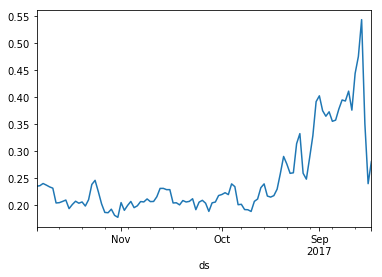

In [14]:
data_dict_train['0x']['y'].plot()

#### Plot test

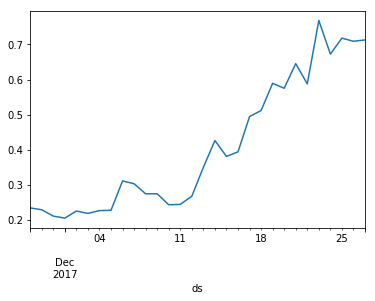

In [15]:
data_dict_test['0x']['y'].sort_index().plot()

#### Create DataFrame that is a subset of the dictionary that is to be fed into the model

In [16]:
model_train = data_dict_train['0x'].loc[:,['ds','y']]
model_test = data_dict_test['0x'].loc[:,['ds','y']]

In [17]:
model_train.sort_index().head()

,ds,y
ds,,
2017-08-16,16-Aug-17,0.280031
2017-08-17,17-Aug-17,0.238935
2017-08-18,18-Aug-17,0.350260
2017-08-19,19-Aug-17,0.543728
2017-08-20,20-Aug-17,0.475262


In [18]:
model_test.sort_index().head()

,ds,y
ds,,
2017-11-28,28-Nov-17,0.234871
2017-11-29,29-Nov-17,0.229552
2017-11-30,30-Nov-17,0.211591
2017-12-01,1-Dec-17,0.205803
2017-12-02,2-Dec-17,0.225993


#### Forecasting using Prophet

#### Create Prophet object and fit it to data

In [19]:
m = Prophet()
m.fit(model_train)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### Use helper function that creates a dataframe for future predictions

In [20]:
future = m.make_future_dataframe(periods=30)
future.tail()

,ds
129,2017-12-23
130,2017-12-24
131,2017-12-25
132,2017-12-26
133,2017-12-27


#### Plot Forecast

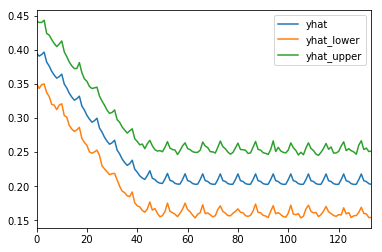

In [21]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].plot()

#### Plot the model including past 

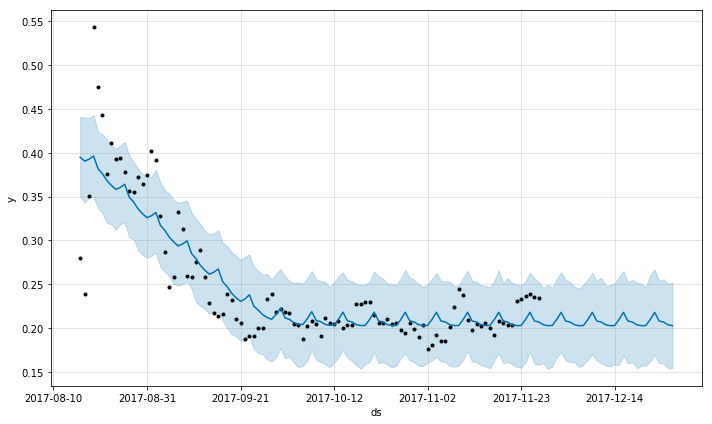

In [22]:
m.plot(forecast);

#### Plot the components 

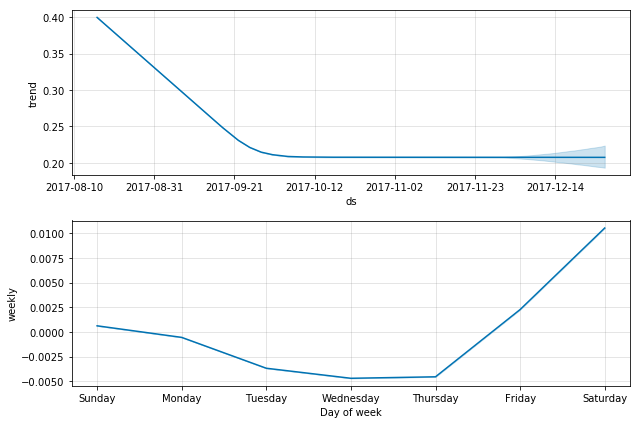

In [23]:
m.plot_components(forecast);

#### Set the index into the date for join

In [24]:
forecast = forecast.set_index('ds')

#### Look at the data

In [25]:
forecast.head()

,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yhat
ds,,,,,,,,,,,,,,,
2017-08-16,0.399735,0.399735,0.399735,0.350669,0.441575,-0.004688,-0.004688,-0.004688,-0.004688,-0.004688,-0.004688,-0.004688,-0.004688,-0.004688,0.395047
2017-08-17,0.395124,0.395124,0.395124,0.343181,0.439906,-0.004538,-0.004538,-0.004538,-0.004538,-0.004538,-0.004538,-0.004538,-0.004538,-0.004538,0.390586
2017-08-18,0.390513,0.390513,0.390513,0.348666,0.439842,0.002276,0.002276,0.002276,0.002276,0.002276,0.002276,0.002276,0.002276,0.002276,0.392790
2017-08-19,0.385902,0.385902,0.385902,0.349803,0.443118,0.010536,0.010536,0.010536,0.010536,0.010536,0.010536,0.010536,0.010536,0.010536,0.396439
2017-08-20,0.381291,0.381291,0.381291,0.337211,0.423902,0.000628,0.000628,0.000628,0.000628,0.000628,0.000628,0.000628,0.000628,0.000628,0.381919


#### Combine the forecast with actual values

In [26]:
final_forecast = forecast[-30:].join(model_test)

#### Subset the output

In [27]:
final_forecast = final_forecast.loc[:,['y','yhat', 'yhat_lower', 'yhat_upper']]

#### Plot the just the forecast

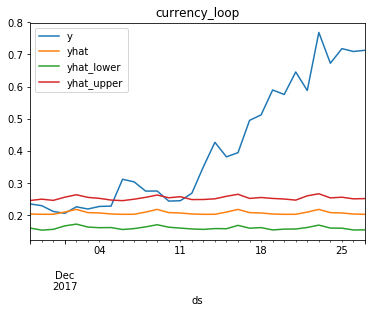

In [28]:
final_forecast.plot(title = 'currency_loop')

#### Get the accuracy

In [29]:
accuracy = np.mean(np.abs(final_forecast['y'] - final_forecast['yhat'])/np.abs(final_forecast['y']))
print(accuracy)

0.38191569118083285


#### Apply the process to other currencies

In [30]:
pred_dict = {}
acc_dict = {}
highest_date_dict = {}
highest_dict = {}
perchange_dict = {}

In [31]:
currency_loop = 'currency_name'

#### Assign Accuracy

In [32]:
pred_dict[currency_loop] = final_forecast
acc_dict[currency_loop] = accuracy 

#### Get the date of the highest point

In [33]:
highest_date_dict[currency_loop] = np.argmax(pred_dict[currency_loop]['yhat'])

In [34]:
float(model_train.head(1)['y'].reset_index(drop = True))

0.234219

#### Save the Highest point

In [35]:
highest_dict[currency_loop] = np.max(pred_dict[currency_loop]['yhat'])

#### Get the Percent change

In [36]:
perchange_dict[currency_loop] = (highest_dict[currency_loop] - float(model_train.head(1)['y'].reset_index(drop = True)))/float(model_train.head(1)['y'])

In [37]:
perchange_dict[currency_loop]

-0.069481247552970249

#### Naive Forecast

In [38]:
naive_forecast = float(model_train['y'].reset_index(drop=True).head(1))

In [39]:
naive_forecast

0.234219

#### Prediction

In [40]:
naive_prediction = pd.DataFrame(model_test['y'].sort_index().reset_index(drop=True))
naive_prediction['forecast'] = naive_forecast
print(naive_prediction)

           y  forecast
0   0.234871  0.234219
1   0.229552  0.234219
2   0.211591  0.234219
3   0.205803  0.234219
4   0.225993  0.234219
5   0.219164  0.234219
6   0.227198  0.234219
7   0.228100  0.234219
8   0.311601  0.234219
9   0.303565  0.234219
10  0.274864  0.234219
11  0.275125  0.234219
12  0.243797  0.234219
13  0.244889  0.234219
14  0.268088  0.234219
15  0.350352  0.234219
16  0.426488  0.234219
17  0.381291  0.234219
18  0.394361  0.234219
19  0.494670  0.234219
20  0.511789  0.234219
21  0.589200  0.234219
22  0.575164  0.234219
23  0.645124  0.234219
24  0.587635  0.234219
25  0.768043  0.234219
26  0.672352  0.234219
27  0.717725  0.234219
28  0.708796  0.234219
29  0.712597  0.234219


#### Get accuracy

In [41]:
np.mean(abs(naive_forecast - model_test['y'].reset_index(drop=True))/model_test['y'].reset_index(drop=True))

0.3283756469460938

### Put it all in a Function 

In [42]:
def forecast_crypto(file="consolidated_coin_data.csv",threshold=50,plot=False,test=True):

    data = pd.read_csv(file)
    data.rename(columns={'High':'y','Date':'ds'}, inplace=True)
    currency_count = data['Currency'].value_counts()
    currency_above_threshold = currency_count.index[data['Currency'].value_counts()>threshold]
    currency_above_threshold = currency_above_threshold.tolist()

    data_dict_train = {}
    if test==True:
        data_dict_test = {}

    for currency in currency_above_threshold:
        _ = data[data['Currency']==currency]
        _.index = pd.to_datetime(_['ds'])

        if test==True:
            data_dict_test[currency] = _[:30]
            data_dict_train[currency] = _[30:]
        else:
            data_dict_train[currency] = _


    pred_dict = {}
    acc_dict = {}
    highest_date_dict = {}
    highest_dict = {}
    perchange_dict = {}

    naive_pred_dict = {}
    naive_acc_dict = {}
    naive_highest_date_dict = {}
    naive_highest_dict = {}
    naive_perchange_dict = {}
    
    #Plots will be saved here
    if not os.path.exists('integrichain_plots'):
        os.makedirs('integrichain_plots')
        
    counter = 0
    for currency_loop in currency_above_threshold:
        counter = counter + 1
        print('Working on ' + currency_loop + '(' + str(counter) + ')')
        
        model_train = data_dict_train[currency_loop].loc[:,['ds','y']]
        
        if test==True:
            model_test = data_dict_test[currency_loop].loc[:,['ds','y']]
        
        #Prophet
        m = Prophet(daily_seasonality=True,yearly_seasonality=False)
        m.fit(model_train)
        
        future = m.make_future_dataframe(periods=30)
        future.tail()

        forecast = m.predict(future)
        if plot==True:
            m.plot(forecast)
            plt.savefig('integrichain_plots/' +str(currency_loop) + '.png')

            m.plot_components(forecast)
            plt.savefig('integrichain_plots/' +str(currency_loop) + '_components.png')
        
        forecast = forecast.set_index('ds')
        
        if test==True:
            final_forecast = forecast[-30:].join(model_test)
            final_forecast = final_forecast.loc[:,['y','yhat', 'yhat_lower', 'yhat_upper']]

            if plot==True:
                final_forecast.plot(title = currency_loop)
                plt.savefig('integrichain_plots/' +str(currency_loop) +'_forecast.png')

            accuracy = np.mean(np.abs(final_forecast['y'] - final_forecast['yhat'])/final_forecast['y'])
            print('Prophet MAPE: ' + str(accuracy))

            acc_dict[currency_loop] = accuracy 

            #Naive
            naive_forecast = float(model_train['y'].reset_index(drop=True).head(1))
            naive_prediction = pd.DataFrame(model_test['y'].sort_index().reset_index(drop=True))
            naive_prediction['yhat'] = naive_forecast#'forecast

            naive_pred_dict[currency_loop] = naive_prediction
            naive_acc_dict[currency_loop] = np.mean(np.abs(naive_forecast - model_test['y'].reset_index(drop=True))/np.abs(model_test['y'].reset_index(drop=True)))
            print('Naive MAPE: ' + str(naive_acc_dict[currency_loop]))
            print()
            if plot==True:
                naive_pred_dict[currency_loop].plot(title = str(currency_loop) + '_naive')
                plt.savefig('integrichain_plots/' +str(currency_loop) +'_naive_forecast.png')
        else:
            final_forecast = forecast.loc[:,['yhat', 'yhat_lower', 'yhat_upper']]
            
            
        final_forecast = final_forecast.reset_index()[-30:]
        final_forecast = final_forecast.set_index('ds')
        pred_dict[currency_loop] = final_forecast
        highest_date_dict[currency_loop] = np.argmax(pred_dict[currency_loop]['yhat'])
        highest_dict[currency_loop] = np.max(pred_dict[currency_loop]['yhat'])
        perchange_dict[currency_loop] = (highest_dict[currency_loop] - float(model_train.head(1)['y'].reset_index(drop = True)))/float(model_train.head(1)['y'])

        plt.close('all')
    return pred_dict, acc_dict, highest_date_dict, highest_dict, perchange_dict,naive_pred_dict,naive_acc_dict
    

In [43]:
start = time.time()
pred_dict, acc_dict, highest_date_dict, highest_dict, perchange_dict,naive_pred_dict,naive_acc_dict = forecast_crypto(plot = True,test=True)
end = time.time()
print(end - start)

Working on nxt(1)
Prophet MAPE: 0.8831193157854519
Naive MAPE: 0.6345306227544566

Working on bitcoindark(2)
Prophet MAPE: 0.2908148896403749
Naive MAPE: 0.24348948166683088

Working on factom(3)
Prophet MAPE: 0.3781275911679046
Naive MAPE: 0.24067608461097995

Working on reddcoin(4)
Prophet MAPE: 0.4982970691827144
Naive MAPE: 0.4116469703289604

Working on stellar(5)
Prophet MAPE: 0.798521202213525
Naive MAPE: 0.6043942029676401

Working on counterparty(6)
Prophet MAPE: 0.5493378477187
Naive MAPE: 0.19282035865796152

Working on feathercoin(7)
Prophet MAPE: 0.6961435803755855
Naive MAPE: 0.33044747206794706

Working on maidsafecoin(8)
Prophet MAPE: 0.2763842163728707
Naive MAPE: 0.225190270719649

Working on burst(9)
Prophet MAPE: 0.6935514461766173
Naive MAPE: 0.4982694590940974

Working on bytecoin-bcn(10)
Prophet MAPE: 0.6019566710437921
Naive MAPE: 0.4318970950751595

Working on bitshares(11)
Prophet MAPE: 0.8128870788627024
Naive MAPE: 0.41336947339494673

Working on syscoin(12)

Prophet MAPE: 0.27087200683468965
Naive MAPE: 0.24002676697949596

Working on xtrabytes(95)
Prophet MAPE: 0.61804330980986
Naive MAPE: 0.6105564112520608

Working on gnosis-gno(96)
Prophet MAPE: 0.8036094312306722
Naive MAPE: 0.22111083000649506

Working on humaniq(97)
Prophet MAPE: 0.6517833479433178
Naive MAPE: 0.3916043623877071

Working on aragon(98)
Prophet MAPE: 0.4588066136470767
Naive MAPE: 0.19322446368579363

Working on qtum(99)
Prophet MAPE: 0.37763219716172003
Naive MAPE: 0.3688783372805345

Working on aeternity(100)
Prophet MAPE: 0.9685848828871133
Naive MAPE: 0.29058154173639933

Working on basic-attention-token(101)
Prophet MAPE: 0.34441615989194047
Naive MAPE: 0.27788656319929467

Working on zencash(102)
Prophet MAPE: 0.11697683891859914
Naive MAPE: 0.14692088497500208

Working on metaverse(103)
Prophet MAPE: 0.2319395808742656
Naive MAPE: 0.22464260755862026

Working on veritaseum(104)
Prophet MAPE: 0.7326173774877575
Naive MAPE: 0.43422388138997625

Working on quantum

INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 24.0.


Prophet MAPE: 0.2233909140342882
Naive MAPE: 0.2371238869844558

Working on icon(177)


INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 23.0.


Prophet MAPE: 0.3737326791054354
Naive MAPE: 0.2897097665649142

Working on red-pulse(178)


INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 22.0.


Prophet MAPE: 0.36493786771795056
Naive MAPE: 0.38705260965501675

Working on etherparty(179)


INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 20.0.


Prophet MAPE: 0.26128698115261895
Naive MAPE: 0.3059965597089649

Working on power-ledger(180)


INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 20.0.


Prophet MAPE: 0.6073251378535836
Naive MAPE: 0.1930388235170328

Working on revain(181)


INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 20.0.


Prophet MAPE: 0.3729708949311703
Naive MAPE: 0.4808379937962437

Working on enjin-coin(182)


INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 19.0.


Prophet MAPE: 0.4622105204542954
Naive MAPE: 0.4805048202569766

Working on electroneum(183)


INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 19.0.


Prophet MAPE: 1.1981442844854704
Naive MAPE: 0.5787004053576961

Working on streamr-datacoin(184)
Prophet MAPE: 0.514217598674663
Naive MAPE: 0.4032489864432295

500.8677613735199


#### Naive Average Accuracy

In [44]:
np.mean(list(naive_acc_dict.values()))

0.36264470511878455

#### Prophet Average Accuracy

In [45]:
np.mean(list(acc_dict.values()))

0.53900821663839893

#### Compare Progression of Accuracy

In [46]:
def prog_acc(dictionary,index_start,index_end):
    acc_list = []
    for key in dictionary:
        acc_list.append(np.mean(abs(dictionary[key].reset_index().loc[index_start:index_end,['yhat']].values-dictionary[key].reset_index().loc[index_start:index_end,['y']].values)/dictionary[key].reset_index().loc[index_start:index_end,['y']].values))
    return np.mean(acc_list)

#### MAPE for just one day Forecast

In [47]:
print('Prophet: ' + str(prog_acc(pred_dict,0,1)))
print('Naive: ' + str(prog_acc(naive_pred_dict,0,1)))

Prophet: 0.327734677161
Naive: 0.112305944162


#### MAPE for just one week Forecast

In [48]:
print('Prophet: ' + str(prog_acc(pred_dict,0,7)))
print('Naive: ' + str(prog_acc(naive_pred_dict,0,7)))

Prophet: 0.354254512955
Naive: 0.163068472521


#### MAPE for second week Forecast

In [49]:
print('Prophet: ' + str(prog_acc(pred_dict,7,14)))
print('Naive: ' + str(prog_acc(naive_pred_dict,7,14)))

Prophet: 0.467719234369
Naive: 0.279483973026


#### MAPE for third week onwards Forecast

In [50]:
print('Prophet: ' + str(prog_acc(pred_dict,21,30)))
print('Naive: ' + str(prog_acc(naive_pred_dict,21,30)))

Prophet: 0.717380401182
Naive: 0.56561602306


#### Performance decreases the longer the forecast

#### Apply Prophet to the whole dataset to forecast next month

In [51]:
start = time.time()
pred_dict, acc_dict, highest_date_dict, highest_dict, perchange_dict,_,_ = forecast_crypto(plot = False,test=False)
end = time.time()
print(end - start)

Working on nxt(1)
Working on bitcoindark(2)
Working on factom(3)
Working on reddcoin(4)
Working on stellar(5)
Working on counterparty(6)
Working on feathercoin(7)
Working on maidsafecoin(8)
Working on burst(9)
Working on bytecoin-bcn(10)
Working on bitshares(11)
Working on syscoin(12)
Working on dash(13)
Working on cloakcoin(14)
Working on verge(15)
Working on gulden(16)
Working on namecoin(17)
Working on viacoin(18)
Working on faircoin(19)
Working on einsteinium(20)
Working on shift(21)
Working on litecoin(22)
Working on monero(23)
Working on nem(24)
Working on emercoin(25)
Working on gamecredits(26)
Working on nav-coin(27)
Working on digitalnote(28)
Working on vertcoin(29)
Working on dogecoin(30)
Working on potcoin(31)
Working on aeon(32)
Working on paccoin(33)
Working on nexus(34)
Working on blocknet(35)
Working on ripple(36)
Working on bitbay(37)
Working on digibyte(38)
Working on blackcoin(39)
Working on bitcoin(40)
Working on monacoin(41)
Working on groestlcoin(42)
Working on eth

#### Forecast of Top Performers and the dates they peak

In [52]:
from collections import Counter 
for k, v in Counter(perchange_dict).most_common(3):
    print(str(k) + ': ' + str(v))
    print('Peaks at: ' + str(highest_date_dict[k]))
    print()

decentraland: 1.26655559037
Peaks at: 2018-01-25 00:00:00

cobinhood: 1.11712959431
Peaks at: 2018-01-22 00:00:00

request-network: 1.0987628498
Peaks at: 2018-01-26 00:00:00

